In [1]:
from run_gom_mp import *
import pandas as pd
import xarray as xr
from datetime import timedelta as delta

from parcels import plotTrajectoriesFile

In [2]:
# RUN SIMULATION
%run -i gom_mp_kernels.py
%run -i run_gom_mp_backwards.py


fieldset, pset = run_gom_mp_backwards('testing_output/b_test.zarr')

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
INFO: Compiled ArrayNurdleAdvectionRK4BeachTestingUnBeachingStokesUVBeachTestingSmagDiff2BeachTestingAgeing2 ==> C:\Users\pojun\AppData\Local\Temp\parcels-tmp\lib030655814ce086ad34d0ad29b5e123f6_0.dll
INFO: Output files are stored in testing_output/b_test.zarr.
100%|██████████| 5184000.0/5184000.0 [06:22<00:00, 13569.47it/s]         


In [3]:
test = xr.open_zarr('testing_output/b_test.zarr')
gom_masks = xr.open_dataset('data/gom_masks_w_inputs.nc')

In [5]:
test_dd  = test.to_dask_dataframe().compute()

In [6]:
test_dd.trajectory.unique()

array([             1544862,              1544863,              1544864,
       ...,              1534739,              1534740,
       -9223372036854775808], dtype=int64)

In [30]:
test_dd[(test_dd['lon'] <= -89.0) & (test_dd['lon'] >= -89.2) & (test_dd['lat'] >= 29.0) & (test_dd['lat'] <= 29.2) ]

,trajectory,obs,age,beached,d2s,dU,dV,lat,lon,time,unbeachCount,z
405302,1538764,18,-1555200.0,0.0,1000.0,0.0,0.0,29.034107,-89.162788,2021-10-18 12:00:00,0.0,0.0
405303,1538764,19,-1641600.0,0.0,1000.0,0.0,0.0,29.077980,-89.134048,2021-10-17 12:00:00,0.0,0.0
405304,1538764,20,-1728000.0,1.0,1000.0,0.0,0.0,29.122068,-89.123413,2021-10-16 12:00:00,0.0,0.0
405305,1538764,21,-1814400.0,1.0,1000.0,0.0,0.0,29.122068,-89.123413,2021-10-15 12:00:00,0.0,0.0
405306,1538764,22,-1900800.0,1.0,1000.0,0.0,0.0,29.122068,-89.123413,2021-10-14 12:00:00,0.0,0.0
405307,1538764,23,-1987200.0,1.0,1000.0,0.0,0.0,29.122068,-89.123413,2021-10-13 12:00:00,0.0,0.0
405308,1538764,24,-2073600.0,1.0,1000.0,0.0,0.0,29.122068,-89.123413,2021-10-12 12:00:00,0.0,0.0
405309,1538764,25,-2160000.0,1.0,1000.0,0.0,0.0,29.122068,-89.123413,2021-10-11 12:00:00,0.0,0.0
405310,1538764,26,-2246400.0,1.0,1000.0,0.0,0.0,29.122068,-89.123413,2021-10-10 12:00:00,0.0,0.0
405311,1538764,27,-2332800.0,1.0,1000.0,0.0,0.0,29.122068,-89.123413,2021-10-09 12:00:00,0.0,0.0


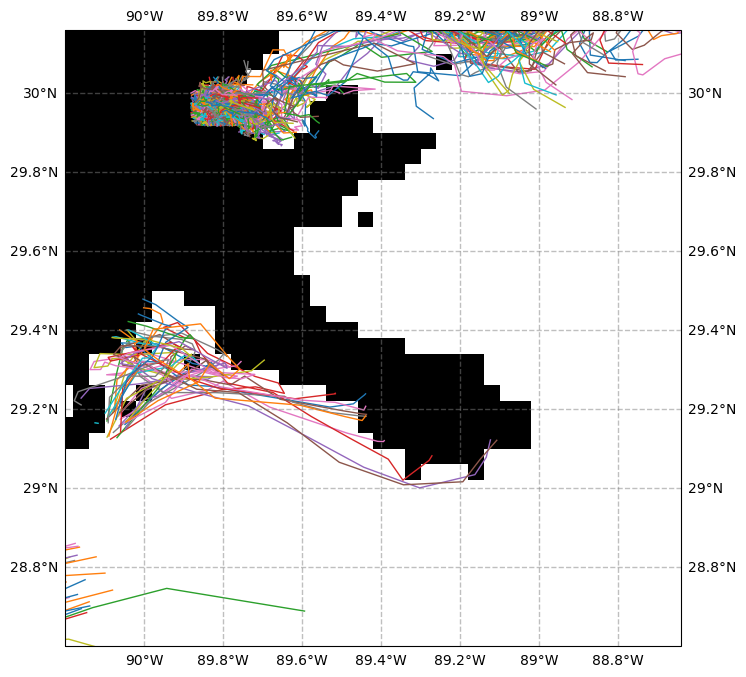

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean 

res_scale= 1/25
lon_bins = np.arange(MIN_LON, MAX_LON, res_scale)
lat_bins = np.arange(MIN_LAT, MAX_LAT, res_scale)

X_land,Y_land = np.meshgrid(gom_masks.landmask['Latitude'],gom_masks.landmask['Longitude'],  indexing='ij')

fig = plt.figure(figsize=(32,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax.coastlines(resolution='50m')
ax.pcolormesh(Y_land, X_land, gom_masks.landmask,cmap='Greys')

ax.set_extent([ -90.2, -88.64, 28.6, 30.16], ccrs.PlateCarree())


_ = ax.plot(test['lon'].T, test['lat'].T, linewidth=1, zorder=1)
# H, xedges, yedges = np.histogram2d(test_dd_clean['lon'], test_dd_clean['lat'], bins=(lon_bins, lat_bins))
# ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap=cmocean.cm.matter , vmin=0.0, rasterized=True)


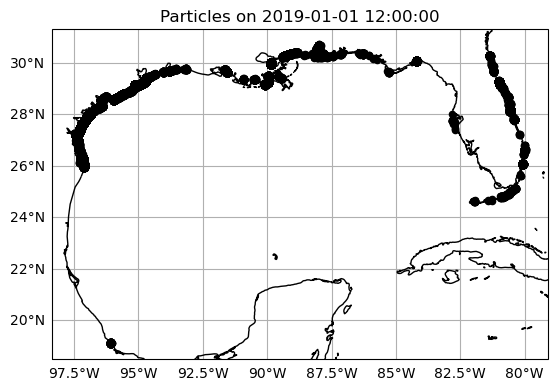

In [2]:
pset.show()

In [12]:

fieldset = get_hycom_fieldset()
set_stokes_fieldset(fieldset)
set_unbeach_field(fieldset)
fieldset.V.cella

array([[18765700., 18780026., 18780026., ..., 18780026., 18780026.,
        18765700.],
       [18761856., 18776178., 18776178., ..., 18776178., 18776178.,
        18761856.],
       [18757556., 18771874., 18771874., ..., 18771874., 18771874.,
        18757556.],
       ...,
       [16774183., 16786988., 16786988., ..., 16786988., 16786988.,
        16774183.],
       [16766907., 16779706., 16779706., ..., 16779706., 16779706.,
        16766907.],
       [16760022., 16772815., 16772815., ..., 16772815., 16772815.,
        16760022.]], dtype=float32)